# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
dataDir = "C:/AV/Carla/CARLA_0.9.13/WindowsNoEditor/PythonAPI/experiments/logs"


In [2]:
exec(open('init_notebook.py').read())

current working dirD:\AV\DataSetExploration\TTI-dataset-tools\src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [19]:
date = "2023-09-11-00-00"
fps=25
minYDisplacement = 5
maxXDisplacement = 9
df = pd.read_csv(os.path.join(dataDir, f"{date}-tracks.csv"))
df["uniqueTrackId"] = df["recordingId"] * 1000000 + df["trackId"]
pedDf = df[df["class"] == "pedestrian"].copy()
otherDf = df[df["class"] != "pedestrian"].copy()

## droping unnecessary states
pedDf = pedDf[(pedDf['state'] != "INITALIZING") & (pedDf['state'] != "FINISHED") & (pedDf['state'] != "CLIMBING_SIDEWALK")].copy()

print(pedDf.tail())

      recordingId  trackId       class  frame          x          y  \
2144            3      443  pedestrian    428 -75.959930  24.730209   
2145            3      443  pedestrian    429 -75.880737  24.741493   
2146            3      443  pedestrian    430 -75.801414  24.754921   
2147            3      443  pedestrian    431 -75.722504  24.768131   
2148            3      443  pedestrian    432 -75.643356  24.778173   

        heading     state  uniqueTrackId  
2144  12.320218  CROSSING        3000443  
2145   7.736403  CROSSING        3000443  
2146  12.297196  CROSSING        3000443  
2147   7.736154  CROSSING        3000443  
2148   3.148057  CROSSING        3000443  


In [20]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='x', 
        yCol='y',
        xVelCol='xVel', 
        yVelCol='yVel', 
        speedCol='speed',
        fps=fps,
    )
transformer = TrajectoryTransformer(colMapper)

In [21]:
transformer.deriveAxisVelocities(pedDf)
transformer.deriveSpeed(pedDf)
transformer.smoothenSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
# pedDf.describe()
pedDf.head()

,recordingId,trackId,class,frame,x,y,heading,state,uniqueTrackId,xVel,yVel,speed,speedSmooth,displacementX,displacementY
0,1,437,pedestrian,100,-83.684166,24.837677,10.967378,CROSSING,1000437,-0.133514,-0.009012,0.133818,0.130558,0.000000,0.000000
1,1,437,pedestrian,101,-83.678825,24.838037,-3.432648,CROSSING,1000437,-0.133514,-0.009012,0.133818,0.119568,0.005341,0.000360
2,1,437,pedestrian,102,-83.679520,24.839523,10.967378,CROSSING,1000437,0.017357,-0.037146,0.041001,0.098535,0.004646,0.001846
3,1,437,pedestrian,103,-83.674263,24.839884,-3.432648,CROSSING,1000437,-0.131416,-0.009012,0.131725,0.087797,0.009903,0.002207
4,1,437,pedestrian,104,-83.675011,24.841208,10.967378,CROSSING,1000437,0.018692,-0.033092,0.038007,0.085070,0.009155,0.003531


In [22]:
pedIds = pedDf["uniqueTrackId"].unique()

In [45]:
aPed = pedDf[pedDf["uniqueTrackId"] == pedIds[0]]
# plt.plot(aPed["yVel"], label='yVel')
# plt.plot(aPed["xVel"], label='xVel')
# plt.legend()
# sns.lineplot(aPed["speed"])
# sns.lineplot(aPed["speedSmooth"])

In [25]:
# smoothSpeed = aPed['speed'].rolling(10).mean()
# sns.lineplot(smoothSpeed, label='avg')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=1)
# sns.lineplot(smoothSpeed, label='gaussian1')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=2)
# sns.lineplot(smoothSpeed, label='gaussian2')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=3)
# sns.lineplot(smoothSpeed, label='gaussian3')

# Trajectory Stats & Visualizations

avg speed 0.29997397579639357
max speed 2.7364592639246834
avg speed 0.7247162277965544
max speed 3.5380572133819213
avg speed 0.6190331712100327
max speed 3.0427784977067933


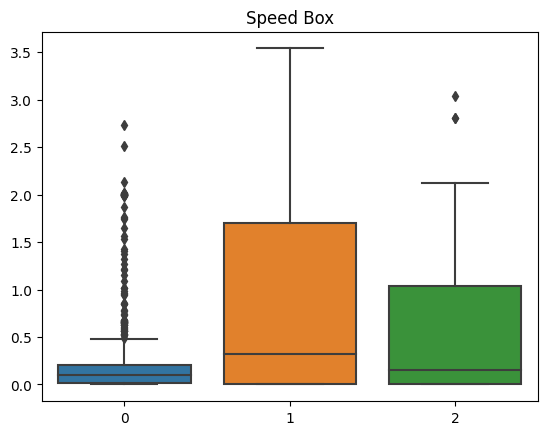

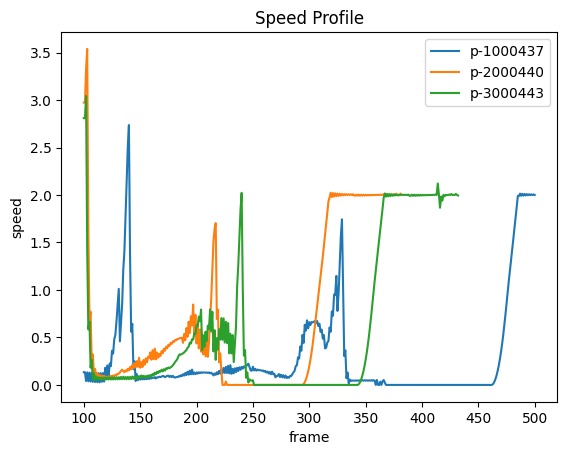

Text(0.5, 1.0, 'Speed Profile')

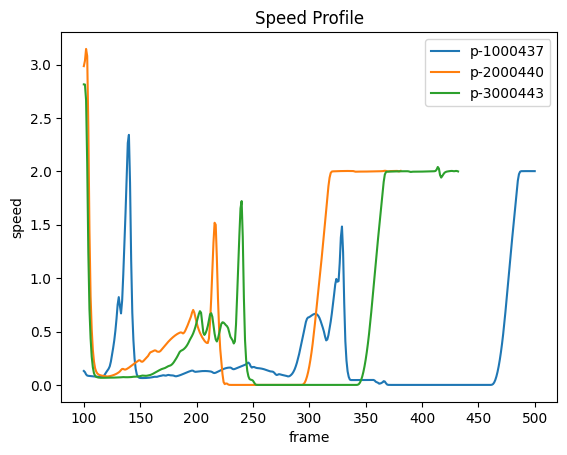

In [78]:
speedSeres = []
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    speedSeres.append(aPed["speed"])
    print("avg speed", aPed["speed"].mean())
    print("max speed", aPed["speed"].max())
sns.boxplot(speedSeres)
plt.title("Speed Box")
plt.show()
x = range(500)
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    sns.lineplot(aPed, x='frame', y="speed", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed")
plt.title("Speed Profile")
plt.show()
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    sns.lineplot(aPed, x='frame', y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed")
plt.title("Speed Profile")

Text(0.5, 1.0, 'Speed Profile')

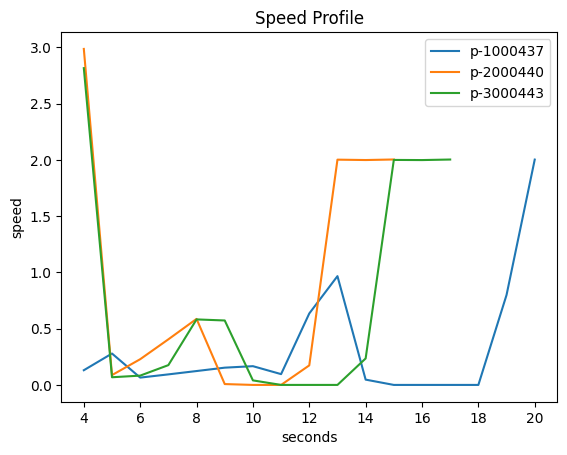

In [79]:
# visualization in seconds
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    aPed = aPed.iloc[::int(fps), :] # frame rate is 25
    seconds = list(range(len(aPed))) + aPed.iloc[0]["frame"] / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("seconds")
plt.ylabel("speed")
plt.title("Speed Profile")


# Frozen State Stats and Visualization

In [57]:
frozenPedDf = pedDf[pedDf['state'] == 'FROZEN'].copy()
pedIds = frozenPedDf["uniqueTrackId"].unique()

359
222
251


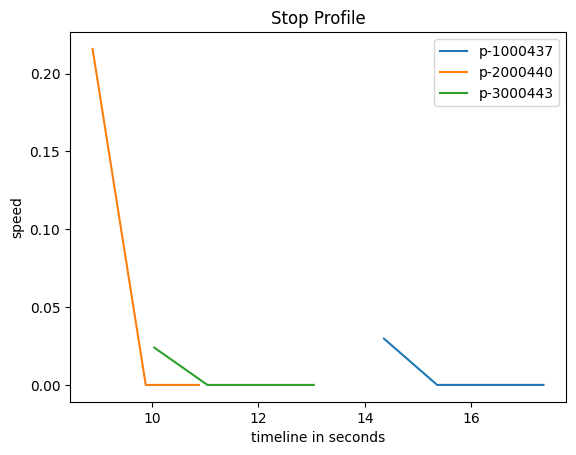

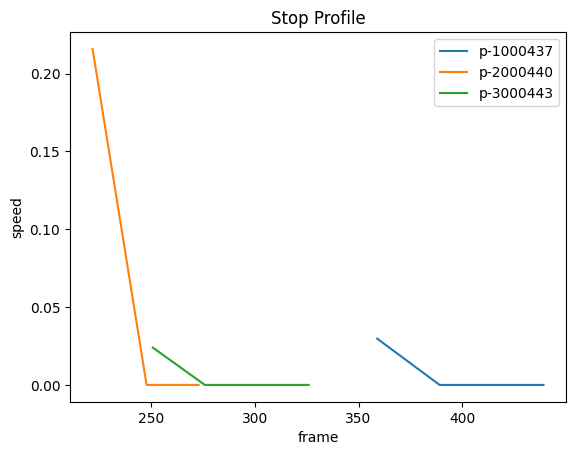

In [80]:
# visualization in seconds
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    aPed = aPed.iloc[::int(fps), :] # frame rate is 25
    seconds = list(range(len(aPed))) + aPed.iloc[0]["frame"] / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("timeline in seconds")
plt.ylabel("speed")
plt.title("Stop Profile")
plt.show()
# visualization in frames
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    aPed = aPed.iloc[::int(fps), :] # frame rate is 25
    sns.lineplot(aPed, x='frame', y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed")
plt.title("Stop Profile")
plt.show()

# Statistics

In [81]:
from collections import defaultdict

In [91]:
colData = defaultdict(lambda: list())
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    colData['uniqueTrackId'].append(pedId)
    colData['speed-avg'].append(aPed['speed'].mean())
    colData['speed-max'].append(aPed['speed'].max())
    colData['speed-min'].append(aPed['speed'].min())
    
    aPedFrozen = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    colData['stop-duration'].append(len(aPedFrozen) / fps)

pedStats = pd.DataFrame(colData)
pedStats.head()

,uniqueTrackId,speed-avg,speed-max,speed-min,stop-duration
0,1000437,0.299974,2.736459,0.0,3.96
1,2000440,0.724716,3.538057,0.0,2.88
2,3000443,0.619033,3.042778,0.0,3.72


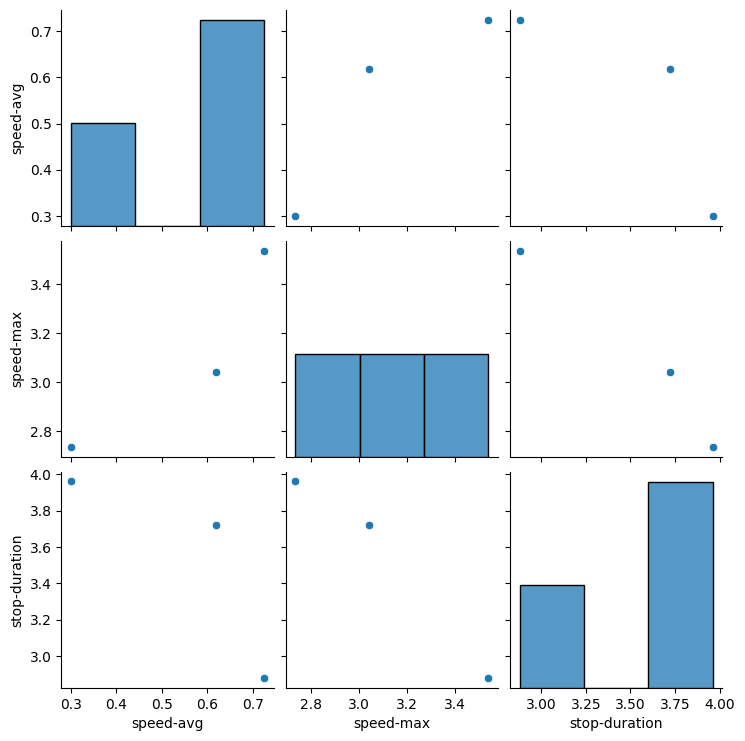

In [93]:
# Stop duration

sns.pairplot(pedStats[['speed-avg', 'speed-max', 'stop-duration']])

plt.xlabel("Correlations")
# plt.ylabel("speed")
# plt.title("Stop Duration")
plt.show()

# Vehicle joint plots

In [ ]:
# 1. create ped vehicle map
# 2. vehicle speed vs ped speed
# 3. vehicle speed vs ped stop duration
# 4. vehicle speed vs ped stop location